# Demonstration using Ananke synthetic Gaia survey data

This notebook makes some plots to illustrate how to use the Ananke synthetic Gaia surveys, available at [ananke.hub.yt](http://ananke.hub.yt) and discussed in detail in [Sanderson et al. 2018]().

The code here uses test data (1/100th the size of the full surveys) to reproduce a few of the figures from the above paper for illustration.

## Setup

Import some libraries and set some options

In [12]:
import numpy as np
import h5py
import glob

from matplotlib import pyplot as pl
pl.rc('text', usetex=True)
pl.rc('font', **{'family':'Computer Modern','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)
from matplotlib.colors import LogNorm,PowerNorm
%matplotlib inline

Tell it where to find the catalog files, and which simulation and LSR you want

In [6]:
nlsr = '0'
sim = 'm12m'
dirbase='/collections/Ananke/ananke/'
#dirname = dirbase+'/'+'sim/lsr_'+nlsr+'/'
dirname = dirbase+sim+'/test/'

Get the list of files belonging to the catalog (with error checking)

In [8]:
fname_pattern = dirname+'lsr-'+nlsr+'-rslice-?.'+sim+'-res7100-md-sliced-gcat-dr2.hdf5'
flist=glob.glob(fname_pattern)
if len(flist)<1:
    raise RuntimeError('No files match '+ fname_pattern)

## Making a map of star counts from a mock Gaia catalog

Makes an all-sky histogram of star counts (like Figure 3 of _[Gaia Collaboration et al. 2018a](https://doi.org/10.1051/0004-6361/201833051)_).

Define variables that set the range of the histogram and collect the star counts 

In [17]:
dn = 10000000  #number of rows to read at once
da = 0.5       #size of one side of pixel in degrees

#X and Y bins for histogram, in degrees
xe = np.arange(-180.,180.5,da)
ye = np.arange(-90.,90.5,da)
X,Y = np.meshgrid(xe[:-1],ye[:-1])

#matrix to hold counts per bin
H_counts = np.zeros_like(X.T)

#file name to save things with
savename = dirname+'galactic-map-'+sim+'-lsr-'+nlsr


Loop over the files and add up the counts per bin

In [18]:
for fn in flist:
    print fn
    f = h5py.File(fn,mode='r')  #open file
    n = f['l'].shape[0]  #get total number of rows
    
    #loop over rows in chunks of size dn to avoid memory overload
    for chunk in range(0,n,dn):
        dc = min(chunk+dn,n)
        print chunk, dc

        #do source count histogram
        h, xe, ye = np.histogram2d(f['l'][chunk:dc],f['b'][chunk:dc],bins=[xe,ye])
        H_counts+=h
    
    #convert to counts/squared arcmin
    H_dens=H_counts/(da*60.)**2

    #checkpoint by saving after each file
    np.savez(savename,
             xe=xe,
             ye=ye,
             X=X,
             Y=Y,
             H_counts=H_counts,
             H_dens=H_dens)

    f.close()

lsr-0-rslice-0.m12m-res7100-md-sliced-gcat-dr2.hdf5
0 9849581
lsr-0-rslice-9.m12m-res7100-md-sliced-gcat-dr2.hdf5
0 8513842


Make the all-sky star-count map

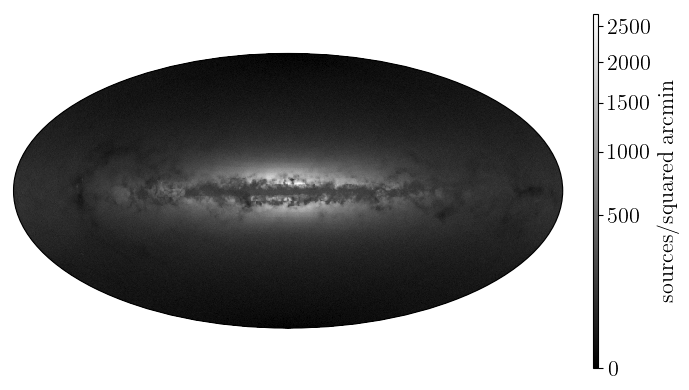

In [19]:
fig = pl.figure(figsize=(7,4))

ax = pl.subplot(111,projection='hammer')
#need to convert longitude and latitude to radians if using a spherical projection like Hammer or Aitoff
X_rad = np.radians(X)
Y_rad = np.radians(Y)

cbh = ax.pcolormesh(X_rad,Y_rad,H_counts.T,norm=PowerNorm(gamma=0.5),cmap='gist_gray',vmin=0,vmax=H_counts.max())

ax.grid('off')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
pl.colorbar(cbh,label='sources/squared arcmin',orientation='vertical',fraction=0.03,aspect=60)

fig.tight_layout()

fig.savefig(savename+'.png',dpi=300)

## Making an H-R diagram from a mock Gaia catalog

Select stars by their tangential velocity and make H-R diagrams for the selections (like Figure 21 of _[Gaia Collaboration et al. 2018b](https://doi.org/10.1051/0004-6361/201832843)_). Unlike the above example, this requires several steps of computation and selection on various different quantities in the catalog.

The following assumes that the relevant packages were imported, and the locations and names of files already defined, by running the first three blocks of this notebook (under "Setup").

As for the all-sky map, define the range and bin size for the histogram

In [29]:
dn = 1000000 #number of rows to read at once
dm = 0.01 #size of magnitude bins in each dimension

#range of color (X direction) and absolute magnitude (Y direction) for histogram
xe = np.arange(-0.9,4.9+dm,dm)
ye = np.arange(-4.9,16.5+dm,dm)
X,Y = np.meshgrid(xe[:-1],ye[:-1])

#list of matrices to hold the results for the three selections on tangential velocity
H = [np.zeros_like(X.T), np.zeros_like(X.T),np.zeros_like(X.T)]


#file name to save things with
savename = dirname+'galactic-hrd-vtan-'+sim+'-lsr-'+nlsr

In [30]:
for fn in flist:
    print fn
    f = h5py.File(fn,mode='r')
    n = f['l'].shape[0]
    for chunk in range(0,n,dn):
        dc = min(chunk+dn,n)
        print '\tprocessing {0} to {1}'.format(chunk, dc)
        
        #this histogram requires some selections on observational uncertainties in the parallax and photometry
        psel = (f['parallax_over_error'][chunk:dc]>10)
        gsel = (f['phot_g_mean_mag_error'][chunk:dc]<0.22)
        bsel = (f['phot_bp_mean_mag_error'][chunk:dc]<0.054)
        rsel = (f['phot_rp_mean_mag_error'][chunk:dc]<0.054)
        
        #it also uses only low-extinction sources
        ebvsel = (f['a_g_val'][chunk:dc]<0.15)
        
        #put all the quality cuts together
        sel=(psel&gsel&rsel&bsel&ebvsel)
        
        #compute the tangential velocity using 1/parallax for the distance (this is why the parallax errors had to be so good)
        #for efficiency, use only the stars that satisfy all the selection criteria
        vt = 4.74 * np.sqrt(f['pmra'][chunk:dc][sel]**2 + f['pmdec'][chunk:dc][sel]**2) / f['parallax'][chunk:dc][sel] 
        
        #select stars in different tangential velocity ranges
        vsel=[(vt<40),(vt>60)&(vt<150),(vt>200)]
        
        #compute the color and absolute magnitude, correcting for reddening and using 1/par for the distance again
        color = f['phot_bp_mean_mag'][chunk:dc][sel] - f['phot_rp_mean_mag'][chunk:dc][sel] + f['e_bp_min_rp_val'][chunk:dc][sel]
        dmod = 5.0 * np.log10(100./f['parallax'][chunk:dc][sel])
        mag = f['phot_g_mean_mag'][chunk:dc][sel] - dmod
        
        #make the histograms for the three velocity cuts
        for i in range(3):
            h, xe, ye = np.histogram2d(color[vsel[i]],mag[vsel[i]],bins=[xe,ye])
            H[i]+=h
    #convert to counts per magnitude squared
    H_dens = [h/(dm**2) for h in H]        
    #simple checkpointing by saving after each file
    np.savez(savename,
             xe=xe,
             ye=ye,
             X=X,
             Y=Y,
             H=H,
             H_dens=H_dens)
    f.close()


lsr-0-rslice-0.m12m-res7100-md-sliced-gcat-dr2.hdf5
	processing 0 to 1000000
	processing 1000000 to 2000000
	processing 2000000 to 3000000
	processing 3000000 to 4000000
	processing 4000000 to 5000000
	processing 5000000 to 6000000
	processing 6000000 to 7000000
	processing 7000000 to 8000000
	processing 8000000 to 9000000
	processing 9000000 to 9849581
lsr-0-rslice-9.m12m-res7100-md-sliced-gcat-dr2.hdf5
	processing 0 to 1000000
	processing 1000000 to 2000000
	processing 2000000 to 3000000
	processing 3000000 to 4000000
	processing 4000000 to 5000000
	processing 5000000 to 6000000
	processing 6000000 to 7000000
	processing 7000000 to 8000000
	processing 8000000 to 8513842


Make a three-panel figure showing the three H-R diagrams

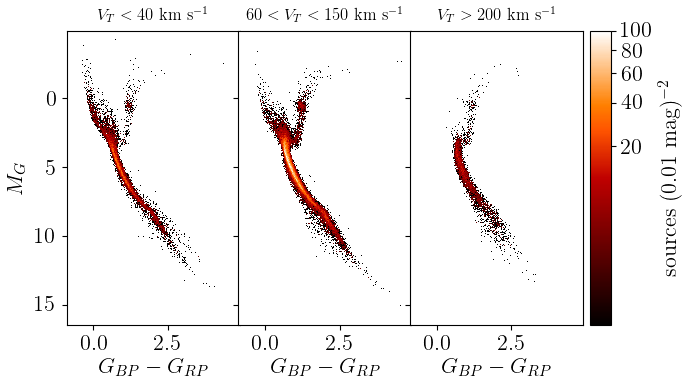

In [36]:
#set up the colormap
from matplotlib import cm
my_cmap=cm.get_cmap('gist_heat')
my_cmap.set_bad('w')
my_cmap.set_under('w')

#make the figure
fig,axs=pl.subplots(1,3,figsize=(7,4),sharey=True,sharex=True)
for i in range(3):
    im = axs[i].pcolormesh(X,Y,H_dens[i].T/1e4,norm=PowerNorm(gamma=0.3),cmap=my_cmap,vmin=1,vmax=1e2)

#axis labels and titles    
axs[0].set_ylim(16.5,-4.9)
axs[0].set_xlim(-0.9,4.9)

axs[0].set_title(r'$V_{T}<40$ km s${}^{-1}$',fontsize=12)
axs[1].set_title(r'$60<V_{T}<150$ km s${}^{-1}$',fontsize=12)
axs[2].set_title(r'$V_{T}>200$ km s${}^{-1}$',fontsize=12)

for i in range(3):
    axs[i].set_xlabel(u'$G_{BP}-G_{RP}$')
axs[0].set_ylabel(u'$M_G$')

#format and add color bar
fig.tight_layout(w_pad=-0.6)
fig.subplots_adjust(right=0.84)
dims = fig.axes[2].get_position().bounds

cbar_ax = fig.add_axes([0.85, dims[1], 0.03, dims[3]])
fig.colorbar(im, cax=cbar_ax, label=r'sources (0.01 mag)${}^{-2}$')

#save
fig.savefig(savename+'.png',dpi=300)